In [1]:
%%bash
if [ -d "data-raw" ] 
then
    echo "Data already downloaded"
else
    kaggle competitions download -c knsi-golem-2
    mkdir "data-raw"
    unzip knsi-golem-2.zip -d "data-raw"
    rm knsi-golem-2.zip
    echo "Data downloaded"
fi
mkdir -p data-prep

Data already downloaded


In [2]:
import time
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.callbacks import ModelCheckpoint
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Prepare labels

In [3]:
y = (
    pd.read_csv('data-raw/y_train.csv', header=None)
    .to_numpy().reshape(-1))
np.save('data-prep/train_labels.npy', y)

## Prepare tabular data

### Utility functions

In [4]:
def plot_percent_nans_in_cols(x):
    percents = []
    for i in range(x.shape[1]):
        percents.append(
            np.count_nonzero(np.isnan(x[:, i])) / x.shape[0])
    percents = np.array(percents)

    plt.figure(figsize=(6, 3))
    plt.hist(percents, bins=200)
    plt.title('% of nans in column')
    plt.show()

In [5]:
def plot_imputed_tab_data(x, x_imp, y=None, idx_x=8, idx_y=9):
    plt.figure(figsize=(16, 8))

    plt.subplot(121)
    if y is not None:
        plt.scatter(x[:, idx_x], x[:, idx_y], c=y)
    else:
        plt.scatter(x[:, idx_x], x[:, idx_y])
    plt.title("pre-imputation")

    plt.subplot(122)
    if y is not None:
        plt.scatter(x_imp[:, idx_x], x_imp[:, idx_y], c=y)
    else:
        plt.scatter(x_imp[:, idx_x], x_imp[:, idx_y])
    plt.title("post-imputation")

    plt.show()

### Training data

In [6]:
# Load data
x_tab = pd.read_csv(f'data-raw/X_train.csv').to_numpy()

In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [8]:
# Impute
x_tab_imp = imputer.fit_transform(x_tab)

Total % of nans: 0.4268
Data shape: (7352, 561)


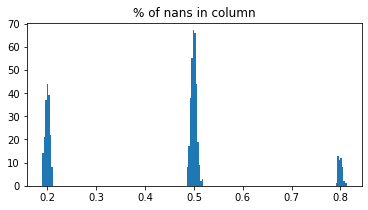

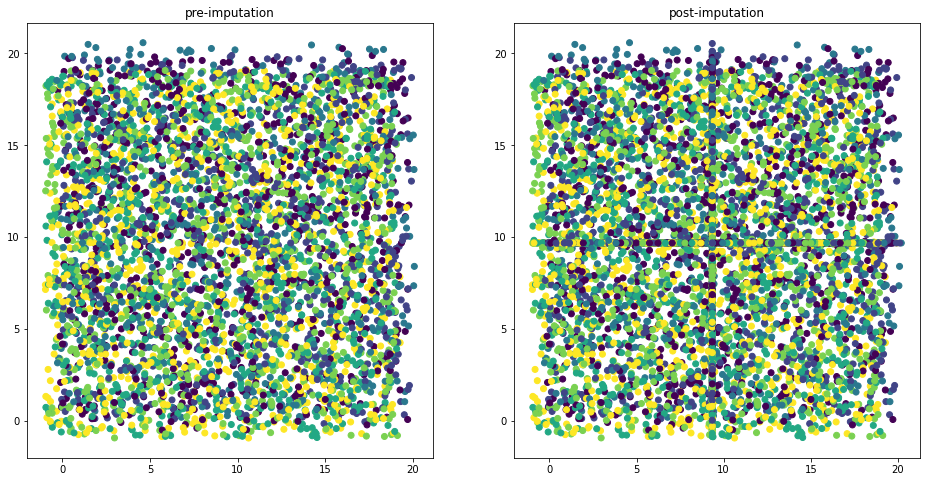

In [9]:
# Visualize
percent = np.count_nonzero(np.isnan(x_tab)) / np.prod(x_tab.shape)
print(f'Total % of nans: {percent:.4f}')

print(f'Data shape: {x_tab_imp.shape}')

plot_percent_nans_in_cols(x_tab)

plot_imputed_tab_data(x_tab, x_tab_imp, y)

In [10]:
# Save data
np.save('data-prep/train_tab.npy', x_tab_imp)

### Test data

In [11]:
# Load data
x_tab = pd.read_csv(f'data-raw/X_test.csv').to_numpy()

In [12]:
# Impute
x_tab_imp = imputer.transform(x_tab)

Total % of nans: 0.4267


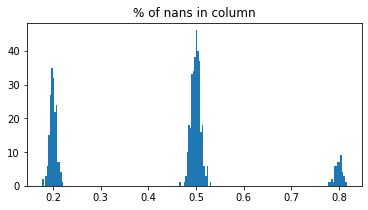

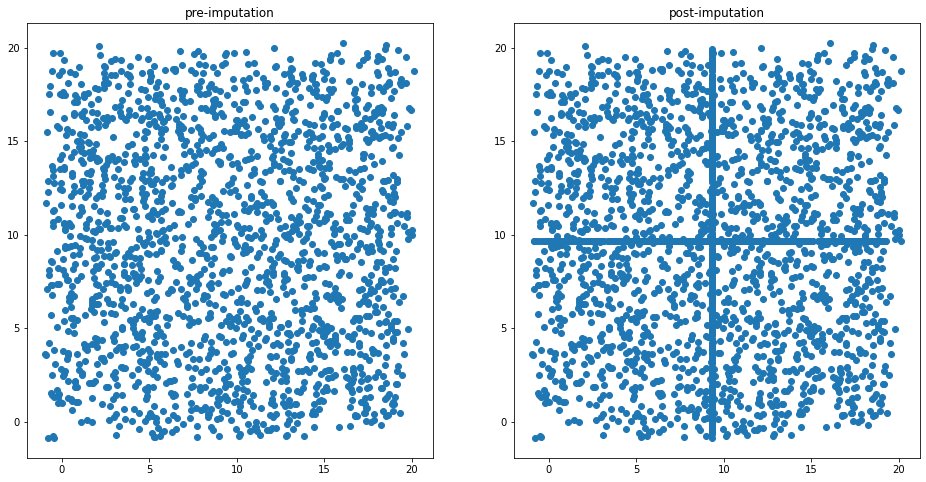

Data shape: (2947, 561)


In [13]:
# Visualize
percent = np.count_nonzero(np.isnan(x_tab)) / np.prod(x_tab.shape)
print(f'Total % of nans: {percent:.4f}')

plot_percent_nans_in_cols(x_tab)

plot_imputed_tab_data(x_tab, x_tab_imp)

print(f'Data shape: {x_tab_imp.shape}')

In [14]:
# Save data
np.save('data-prep/test_tab.npy', x_tab_imp)

## Prepare sequential data

### Utility functions

In [15]:
def load_seq_data(type_):
    NAMES = [
        'body_acc_x_', 'body_acc_y_', 'body_acc_z_',
        'body_gyro_x_', 'body_gyro_y_', 'body_gyro_z_',
        'total_acc_x_', 'total_acc_y_', 'total_acc_z_']
    seqs = []
    for name in NAMES:
        seq = pd.read_csv(
            f'data-raw/{name}{type_}.csv', header=None, index_col=0).to_numpy()
        seq[seq == 0] = np.nan
        seqs.append(seq)

    return seqs

In [16]:
interp1d_ = partial(interp1d, fill_value='extrapolate')

def impute(x_seqs):
    print('Interpolating', end='')
    start = time.time()

    x_seqs_imp = []
    for x_seq in x_seqs:
        x_seq_imp = []
        for vals in x_seq:
            args = np.arange(0, len(vals))
            args_, vals_ = [], []
            for arg, val in zip(args, vals):
                if not np.isnan(val):
                    args_.append(arg)
                    vals_.append(val)

            # Interpolation
            vals_imp = (
                interp1d_(args_, vals_, kind='linear')(args)
                + interp1d_(args_, vals_, kind='quadratic')(args)) / 2

            # Clipping
            margin = 0.5 * (np.nanmax(vals) - np.nanmin(vals))
            low = np.nanmin(vals) - margin
            high = np.nanmax(vals) + margin
            vals_imp = np.clip(vals_imp, low, high)

            x_seq_imp.append(vals_imp)
        x_seqs_imp.append(np.array(x_seq_imp))
        print('.', end='')
    print()
    minutes, seconds = divmod(time.time() - start, 60)
    print(f'Finished in {int(minutes)}m {int(seconds)}s')

    return x_seqs_imp

In [17]:
def plot_percent_nans_in_sample(x_seqs):
    percents = []
    for x_seq in x_seqs:
        for sample in x_seq:
            percents.append(
                np.count_nonzero(np.isnan(sample)) / sample.shape[0])
    percents = np.array(percents)

    plt.figure(figsize=(6, 3))
    plt.hist(percents, bins=65)
    plt.title('% of nans in sample');
    plt.show()

In [18]:
def plot_imputation(x_seqs, x_seqs_imp, idx=0):
    n_plots = len(x_seqs)
    plt.figure(figsize=(16, 4 * n_plots))
    for i, (x_seq, x_seq_imp) in enumerate(zip(x_seqs, x_seqs_imp)):
        plt.subplot(n_plots, 1, i + 1)

        sample = x_seq[idx]
        sample_imp = x_seq_imp[idx]

        x = np.arange(0, len(sample))

        plt.plot(x, sample_imp, c='red')
        plt.scatter(x, sample)
    plt.show()

### Training data

In [19]:
# Load data
x_seqs = load_seq_data('train')

In [20]:
# Impute
x_seqs_imp = impute(x_seqs)

Interpolating.........
Finished in 0m 35s


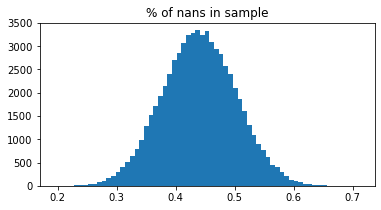

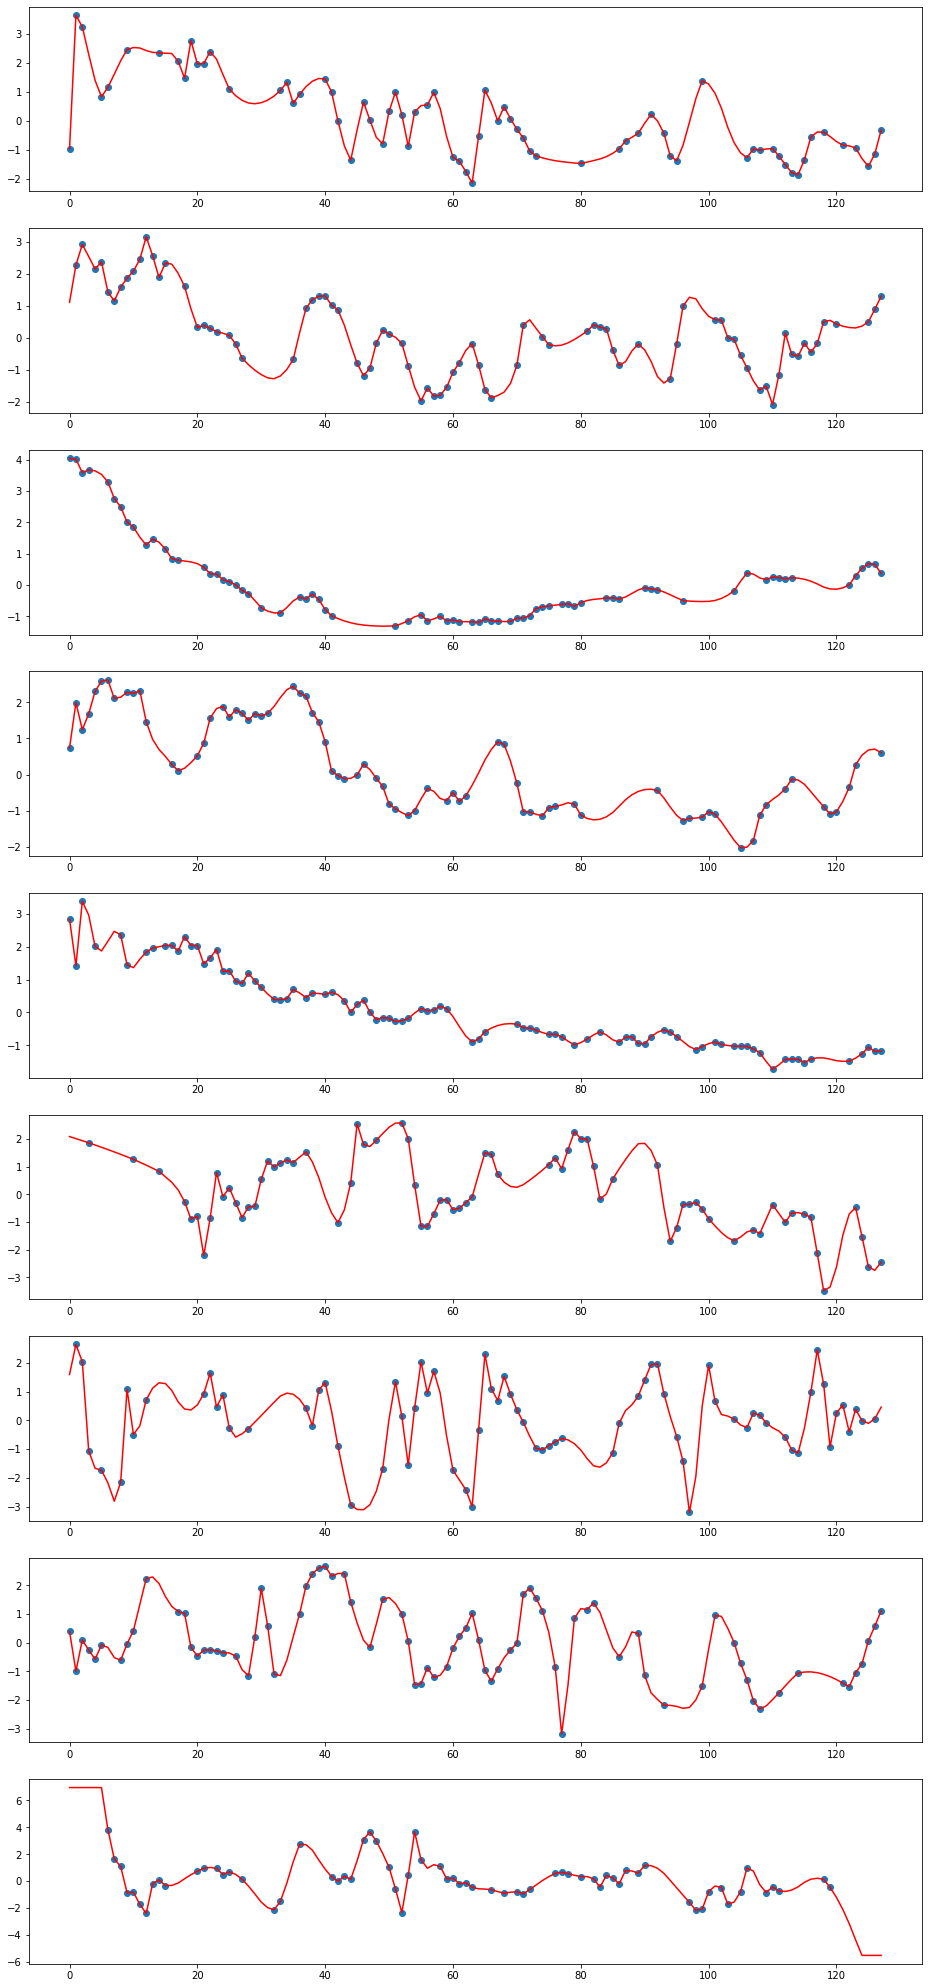

Data shape: (7352, 128, 9)


In [21]:
# Visualize
plot_percent_nans_in_sample(x_seqs)

plot_imputation(x_seqs, x_seqs_imp)

x_seqs_imp = np.stack(x_seqs_imp, axis=2)
print(f'Data shape: {x_seqs_imp.shape}')

In [22]:
# Save data
np.save('data-prep/train_seq.npy', x_seqs_imp)

### Test data

In [23]:
# Load data
x_seqs = load_seq_data('test')

In [24]:
# Impute
x_seqs_imp = impute(x_seqs)

Interpolating.........
Finished in 0m 14s


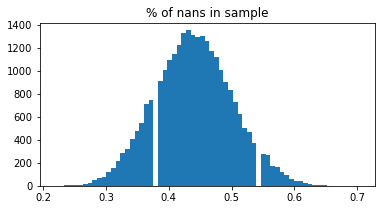

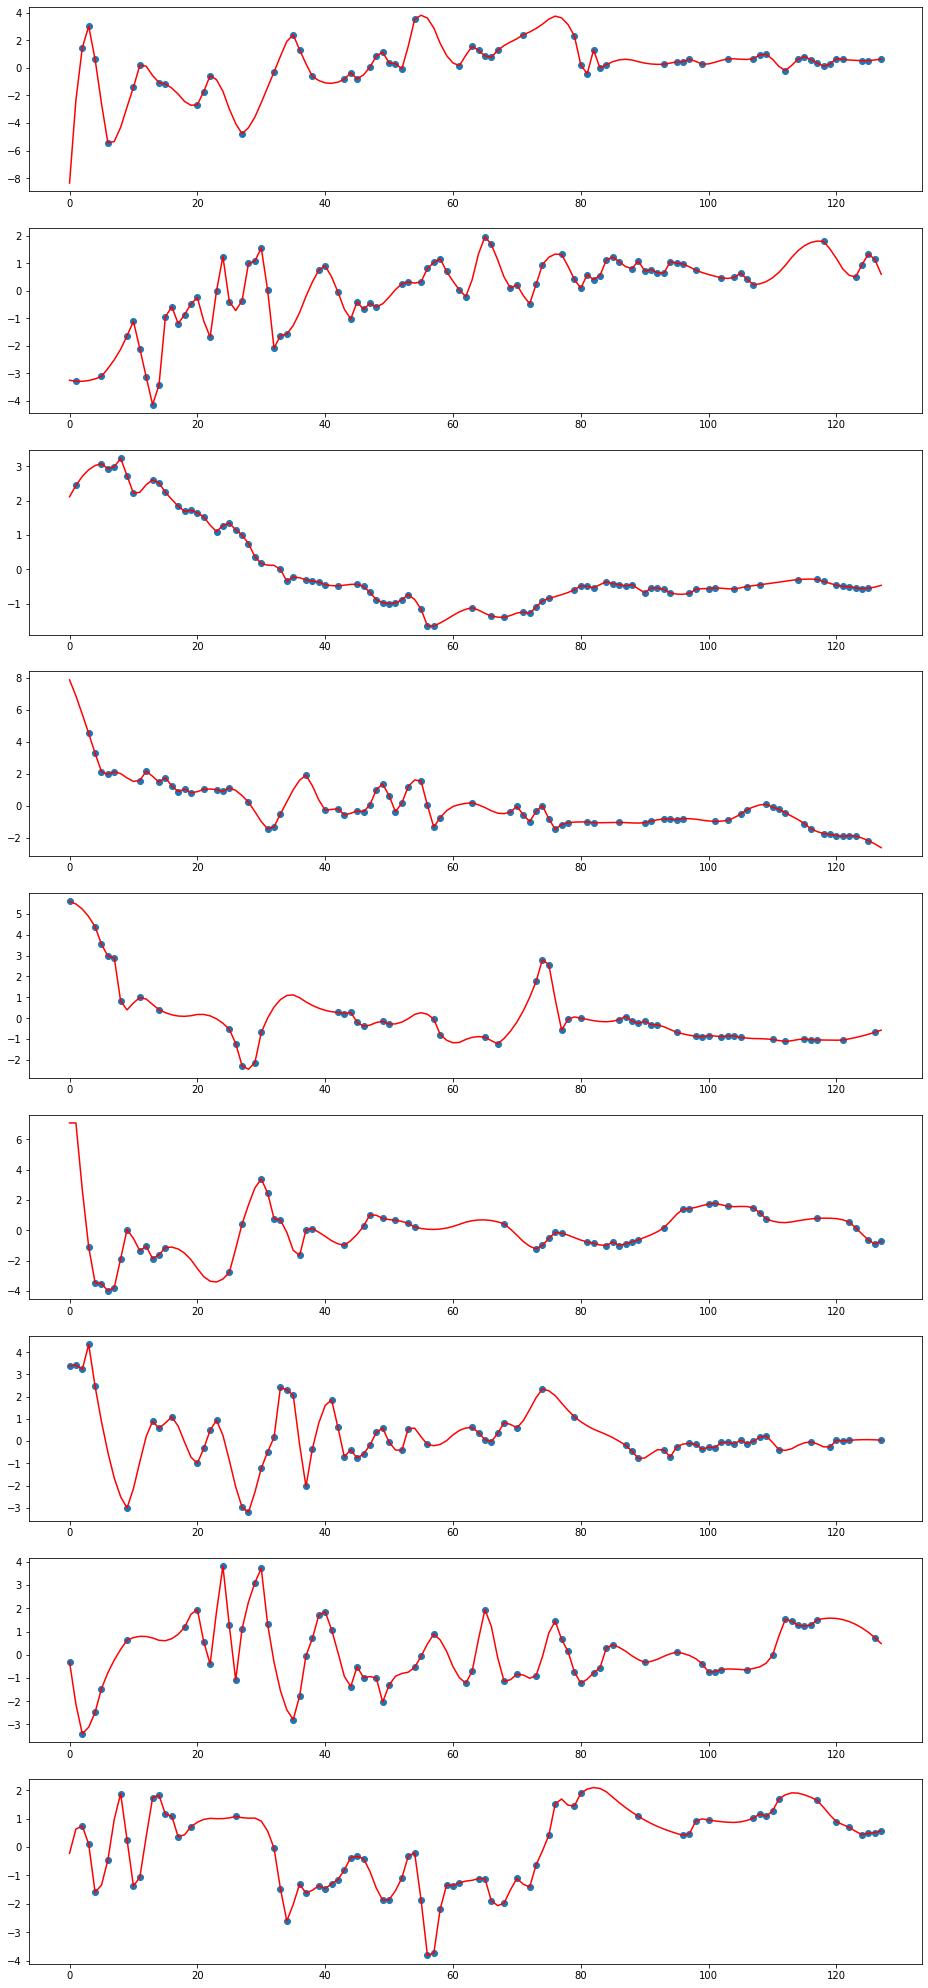

Data shape: (2947, 128, 9)


In [25]:
# Visualize
plot_percent_nans_in_sample(x_seqs)

plot_imputation(x_seqs, x_seqs_imp)

x_seqs_imp = np.stack(x_seqs_imp, axis=2)
print(f'Data shape: {x_seqs_imp.shape}')

In [26]:
# Save data
np.save('data-prep/test_seq.npy', x_seqs_imp)

## Random forest

In [27]:
# Load training data
train_x_tab = np.load('data-prep/train_tab.npy')
train_x_seq = np.load('data-prep/train_seq.npy')

train_x = np.concatenate(
    (train_x_tab, train_x_seq.reshape(train_x_seq.shape[0], -1)),
    axis=1)
train_y = np.load('data-prep/train_labels.npy')

print(f'Data shape: {train_x.shape} {train_y.shape}')

Data shape: (7352, 1713) (7352,)


In [28]:
# # Cross validation
# n_estimators = [512, 768]
# max_depth = [35, 40, 45, 50]

# print('id\tn_est\tmax_d\taccuracy')
# for i, (ne, md) in enumerate(product(n_estimators, max_depth), 1):
#     print(i, ne, md, sep='\t', end='\t')
#     clf = RandomForestClassifier(
#         n_estimators=ne, max_depth=md, n_jobs=-1)
#     print(np.mean(cross_val_score(clf, X, y, cv=10)))

In [29]:
# Train classifier
clf = RandomForestClassifier(
    max_depth=40, n_estimators=1024, n_jobs=-1)
clf.fit(train_x, train_y)

RandomForestClassifier(max_depth=40, n_estimators=1024, n_jobs=-1)

In [30]:
# Load test data
test_x_tab = np.load('data-prep/test_tab.npy')
test_x_seq = np.load('data-prep/test_seq.npy')

test_x = np.concatenate(
    (test_x_tab, test_x_seq.reshape(test_x_seq.shape[0], -1)),
    axis=1)

print(f'Data shape: {test_x.shape}')

Data shape: (2947, 1713)


In [31]:
# Predict
test_y_pred = clf.predict(test_x)

In [32]:
# Save submission
with open('submission.csv', 'w') as fh:
    fh.write('id,Category\n')
    for i, l in enumerate(test_y_pred):
        fh.write(f'{i},{l}\n')

## Neural network

In [33]:
# Load data
train_x_tab = np.load('data-prep/train_tab.npy')
train_x_seq = np.load('data-prep/train_seq.npy')
train_y = np.load('data-prep/train_labels.npy') - 1

In [34]:
# Prepare dataloaders
train_x_tab, val_x_tab, train_x_seq, val_x_seq, train_y, val_y = train_test_split(
    train_x_tab, train_x_seq, train_y, test_size=0.1, random_state=1234)

train_loader = DataLoader(
    TensorDataset(torch.FloatTensor(train_x_tab), torch.FloatTensor(train_x_seq), torch.LongTensor(train_y)),
    batch_size=250, shuffle=True, num_workers=7)
val_loader = DataLoader(
    TensorDataset(torch.FloatTensor(val_x_tab), torch.FloatTensor(val_x_seq), torch.LongTensor(val_y)),
    batch_size=250, shuffle=False, num_workers=7)

In [35]:
class Classifier(pl.LightningModule):
    
    def __init__(self):
        super().__init__()

        self.tab_lin = nn.Sequential(
            nn.Linear(561, 128),
            nn.ReLU())
        self.seq_rnn = nn.LSTM(
            input_size=9, hidden_size=64, num_layers=2,
            batch_first=True, bidirectional=True)

        self.clf = nn.Sequential(
            nn.Dropout(0.15),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(128, 6))
        
        self.train_acc = pl.metrics.Accuracy()
        self.val_acc = pl.metrics.Accuracy()
        
    def forward(self, x_tab, x_seq):
        x_tab = self.tab_lin(x_tab)
        
        x_seq, *_ = self.seq_rnn(x_seq)
        x_seq = torch.mean(x_seq, dim=1)
        
        x = torch.cat((x_tab, x_seq), dim=1)
        x = self.clf(x)

        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_tab, x_seq, y = train_batch
        y_pred = self(x_tab, x_seq)
        loss = F.cross_entropy(y_pred, y)
        self.log('loss/train', loss)
        self.log('acc/train_step', self.train_acc(F.softmax(y_pred, dim=1), y))
        return loss

    def training_epoch_end(self, outs):
        self.log('acc/train_epoch', self.train_acc.compute())

    def validation_step(self, val_batch, batch_idx):
        x_tab, x_seq, y = val_batch
        y_pred = self(x_tab, x_seq)
        loss = F.cross_entropy(y_pred, y)
        self.log('loss/val', loss)
        self.log('acc/val', self.val_acc(F.softmax(y_pred, dim=1), y), on_epoch=True)

In [36]:
# Train classifier
clf = Classifier()
checkpoint_callback = ModelCheckpoint(monitor='loss/val', save_top_k=3, mode='min')
trainer = pl.Trainer(gpus=1, max_steps=2000, callbacks=[checkpoint_callback])
trainer.fit(clf, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | tab_lin   | Sequential | 71.9 K
1 | seq_rnn   | LSTM       | 137 K 
2 | clf       | Sequential | 33.7 K
3 | train_acc | Accuracy   | 0     
4 | val_acc   | Accuracy   | 0     
-----------------------------------------
243 K     Trainable params
0         Non-trainable params
243 K     Total params
0.973     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [37]:
# Load test data
test_x_tab = np.load('data-prep/test_tab.npy')
test_x_seq = np.load('data-prep/test_seq.npy')

test_x_tab = torch.FloatTensor(test_x_tab)
test_x_seq = torch.FloatTensor(test_x_seq)

In [38]:
# Predict
clf = Classifier.load_from_checkpoint(
    checkpoint_callback.best_model_path)
clf.eval()
with torch.no_grad():
    test_y_pred = clf(test_x_tab, test_x_seq)
test_y_pred = test_y_pred.argmax(dim=1).numpy() + 1

In [39]:
# Save submission
with open('submission.csv', 'w') as fh:
    fh.write('id,Category\n')
    for i, l in enumerate(test_y_pred):
        fh.write(f'{i},{l}\n')